In [1]:
# Libraries to load
import pandas as pd
import numpy as np 
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# data visualization packages 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
pd.set_option('max_columns', None)
import pandas_profiling

# machine learning packages (sklearn + xgboost)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')
np.random.seed(123)

In [2]:
# Load DF
df = pd.read_csv('./data/cleaned_df.csv')

In [3]:
# Format Readmitted
df['readmitted'] = df.readmitted.map({'No':0,'Yes':1})

# Dropping Features

In [4]:
#shortest drop list - no patients take these medications
df = df.drop(columns = ["examide", "citoglipton"])

# Feature Engineering

In [5]:
# Group admission type by Emergency (Emergency, Trauma Center, and Urgent), Elective, and Other

def modadtype(series):
    
    def newcat(x):
        if x == 1 or x == 2 or x == 7: return "Emergency"
        elif x == 3: return "Elective"
        else: return "Other"
        
    return series.apply(newcat)

df.admission_type_id = modadtype(df.admission_type_id)

In [6]:
# Group admission source by Referral, Emergency, and Other

def modadsourc(series):
    
    def newcat(x):
        if x == 1 or x == 2 or x == 3: return "Referral"
        elif x == 7: return "Emergency"
        else: return "Other"
        
    return series.apply(newcat)

df.admission_source_id = modadsourc(df.admission_source_id)

In [7]:
## Group discharge dispo by Home or Not_Home discharge

def moddisch(series):
    
    def home(x):
        if x == 1: return "Home"
        else: return "Not_Home"
    
    return series.apply(home)

df.discharge_disposition_id = moddisch(df.discharge_disposition_id)

## Other method - Remove Expired or Hospice-bound Patients

#remove only hospice bound and expired
# df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [8]:
# Change medication to binary take vs not take - play with post model creation
#for med in medication:
    #df[med] = df[med].map({'Up':1, 'Down':1, 'Steady':1, 'No':0})


# medication = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
#        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
#        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
#        'tolazamide', 'insulin',
#        'glyburide-metformin', 'glipizide-metformin',
#        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#        'metformin-pioglitazone']

In [9]:
# Group age by most common categories
age_id = {'[0-10)':'30 or Under', 
          '[10-20)':'30 or Under', 
          '[20-30)':'30 or Under', 
          '[30-40)':'30 to 60', 
          '[40-50)':'30 to 60', 
          '[50-60)':'30 to 60',
          '[60-70)':'30 to 60', 
          '[70-80)':'Over 60', 
          '[80-90)':'Over 60', 
          '[90-100)':'Over 60'}
df['age'] = df.age.replace(age_id)

In [10]:
# Group race by most common categories
race_id = {'Caucasian':'Caucasian', 
          'AfricanAmerican':'AfricanAmerican', 
          'Other':'Other', 
          'Asian':'Other', 
          'Hispanic':'Other', 
          'unknown':'Missing',}
df['race'] = df.race.replace(race_id)

In [11]:
# Inspect Unknown/Invalid results for Gender
df[df['gender'].str.contains('Unknown/Invalid')]

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
22926,Other,Unknown/Invalid,Over 60,Elective,Home,Referral,1,5,5,22,0,0,0,414,411,401,4,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,0
55129,Missing,Unknown/Invalid,30 to 60,Emergency,Home,Emergency,1,38,1,6,0,0,0,808,873,E813,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
59490,Missing,Unknown/Invalid,Over 60,Emergency,Not_Home,Emergency,8,59,2,21,0,0,0,850,805,808,9,None,None,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Ch,Yes,0


In [12]:
# Only 3 values of unknown gender; drop those observations
df = df[df.gender != "Unknown/Invalid"]

In [13]:
# Create a function to group diagnostic codes by range as well as separating diabetes specifically; group symptoms with major disease category

def diag_grouper(series):
    
    '''takes input as df.col and outputs diagnostic code groupings'''
    
    def no_str(x):
        
        '''takes input as an element of a series and pulls code for diabetes specific disease and E/V categories'''
        
        if '250' in x: return '9999'
        elif 'E' in x: return '123456'
        elif 'V' in x: return '123456'
        elif x == 'missing': return '-654321'
        else: return x
    
    series = series.apply(no_str)
    
    series = series.astype(float)
    
    def num_categ(x):
        
        '''takes input as an element of a series and saves each range as a numerical placeholder'''
        
        if 1 <= x <= 139: return 10000
        elif 140 <= x <= 239: return 10001
        elif 240 <= x <= 279: return 10002
        elif 280 <= x <= 289: return 10003
        elif 290 <= x <= 319: return 10004
        elif 320 <= x <= 359: return 10005
        elif 360 <= x <= 389: return 10006
        elif 390 <= x <= 459 and x == 786: return 10007
        elif 460 <= x <= 519 and x == 787: return 10008
        elif 520 <= x <= 579 and x == 787: return 10009
        elif 580 <= x <= 629 and x == 788: return 10010
        elif 630 <= x <= 679: return 10011
        elif 680 <= x <= 709 and x == 782: return 10012
        elif 710 <= x <= 739: return 10013
        elif 740 <= x <= 759: return 10014
        elif 780 <= x <= 781 and x == 784 and 790 <= x <= 799: return 10015
        elif 800 <= x <= 999: return 10016
        else: return x
        
    series = series.apply(num_categ)
    
    def text_convert(x):
        
        '''takes input as an element of a series and converts each placeholder to string format'''
        
        if x == 10000: return "Other"
        elif x == 10001: return "Neoplasms"
        elif x == 10002: return "Other"
        elif x == 10003: return "Other"
        elif x == 10004: return "Other"
        elif x == 10005: return "Other"
        elif x == 10006: return "Other"
        elif x == 10007: return "Circulatory Disease"
        elif x == 10008: return "Respiratory Disease"
        elif x == 10009: return "Digestive Disease"
        elif x == 10010: return "Genitourinary"
        elif x == 10011: return "Other"
        elif x == 10012: return "Other"
        elif x == 10013: return "Musculoskeletal Disease"
        elif x == 10014: return "Other"
        elif x == 10015: return "Other"
        elif x == 10016: return "Injury and Poisoning"
        elif x == 9999: return "Diabetes"
        elif x == 123456: return "Other"
        elif x == -654321: return "Other"
    
    return series.apply(text_convert)

In [14]:
# Apply diag_grouper to the data frame
df.diag_1 = diag_grouper(df.diag_1)
df.diag_2 = diag_grouper(df.diag_2)
df.diag_3 = diag_grouper(df.diag_3)

In [15]:
# Create boolean masks for the columns in question and convert to int
Circ = df[['diag_1','diag_2','diag_3']].isin(['Circulatory Disease']).astype(int)
Resp = df[['diag_1','diag_2','diag_3']].isin(['Respiratory Disease']).astype(int)
Digest = df[['diag_1','diag_2','diag_3']].isin(['Digestive Disease']).astype(int)
Diab = df[['diag_1','diag_2','diag_3']].isin(['Diabetes']).astype(int)
Genit = df[['diag_1','diag_2','diag_3']].isin(['Genitourinary']).astype(int)
Muscu = df[['diag_1','diag_2','diag_3']].isin(['Musculoskeletal Disease']).astype(int)
Neop = df[['diag_1','diag_2','diag_3']].isin(['Neoplasms']).astype(int)
Inj = df[['diag_1','diag_2','diag_3']].isin(['Injury and Poisoning']).astype(int)
Othr = df[['diag_1','diag_2','diag_3']].isin(['Other']).astype(int)

In [16]:
# Sum the column amounts
Circulatory = (Circ['diag_1'] + Circ['diag_2'] + Circ['diag_3'])
Respiratory = Resp['diag_1'] + Resp['diag_2'] + Resp['diag_3']
Digestive = Digest['diag_1'] + Digest['diag_2'] + Digest['diag_3']
Diabetes = Diab['diag_1'] + Diab['diag_2'] + Diab['diag_3']
Injury = Inj['diag_1'] + Inj['diag_2'] + Inj['diag_3']
Genitourinary = Genit['diag_1'] + Genit['diag_2'] + Genit['diag_3']
Musculoskeletal = Muscu['diag_1'] + Muscu['diag_2'] + Muscu['diag_3']
Neoplasms = Neop['diag_1'] + Neop['diag_2'] + Neop['diag_3']
Other = Othr['diag_1'] + Othr['diag_2'] + Othr['diag_3']

In [17]:
# Create new df of new diag columns; convert back to boolean then back to int to binarize
newcollist = [Circulatory, Respiratory, Digestive, Diabetes, Injury, Genitourinary, Musculoskeletal, Neoplasms, Other]
newcols = pd.concat(newcollist, axis = 1)
newcols.columns = ['diag_Circulatory', 'diag_Respiratory', 'diag_Digestive', 'diag_Diabetes', 'diag_Injury',
                   'diag_Genitourinary', 'diag_Musculoskeletal', 'diag_Neoplasms','diag_Other']
newcols = newcols.astype(bool).astype(int)

In [18]:
# Drop OG diags and add new
df = df.drop(columns = ['diag_1','diag_2','diag_3'])
df = pd.concat([df,newcols],axis=1)

# Separation for Scaling and Encoding

In [19]:
# identify cat and num types for cat dummification
categorical = df.drop(columns = ['time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
        'number_diagnoses', 'diag_Circulatory', 'diag_Respiratory',
       'diag_Digestive', 'diag_Diabetes', 'diag_Neoplasms', 'diag_Injury', 
       'diag_Genitourinary', 'diag_Musculoskeletal', 
        'diag_Other','readmitted'])
numerical = df.drop(columns = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 
       'max_glu_serum', 'A1Cresult', 'diag_Circulatory', 'diag_Respiratory',
       'diag_Digestive', 'diag_Diabetes', 'diag_Injury', 'diag_Other',                        
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'diag_Genitourinary', 'diag_Musculoskeletal', 'diag_Neoplasms',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','readmitted'])


In [20]:
# Separation of features from target for dummification

X = df.drop('readmitted', axis = 1)
y = df['readmitted']

In [21]:
X = pd.get_dummies(X, columns = categorical.columns)

#### Recombine data frame for 80/20 split

In [22]:
df = X.assign(readmitted = y)

In [23]:
# Perform and 80/20 split of the data
X = df.drop('readmitted', axis = 1)
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)

In [24]:
#rfe cv

In [25]:
#X_train[numerical.columns] = StandardScaler().fit_transform(X_train[numerical.columns])

In [26]:
X_train

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,diag_Circulatory,diag_Respiratory,diag_Digestive,diag_Diabetes,diag_Injury,diag_Genitourinary,diag_Musculoskeletal,diag_Neoplasms,diag_Other,race_AfricanAmerican,race_Caucasian,race_Missing,race_Other,gender_Female,gender_Male,age_30 or Under,age_30 to 60,age_Over 60,admission_type_id_Elective,admission_type_id_Emergency,admission_type_id_Other,discharge_disposition_id_Home,discharge_disposition_id_Not_Home,admission_source_id_Emergency,admission_source_id_Other,admission_source_id_Referral,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,acetohexamide_No,acetohexamide_Steady,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_No,tolbutamide_Steady,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_No,troglitazone_Steady,tolazamide_No,tolazamide_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
42357,2,60,0,15,0,0,0,9,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1
42094,3,55,0,10,0,0,0,9,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1
70235,5,51,0,13,0,0,0,9,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1
59092,5,51,3,24,0,0,0,9,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1
32317,12,10,2,12,0,0,0,9,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20571,3,43,0,11,0,0,0,5,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1
25809,2,33,0,8,0,0,0,7,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,

# Balancing the Data Set

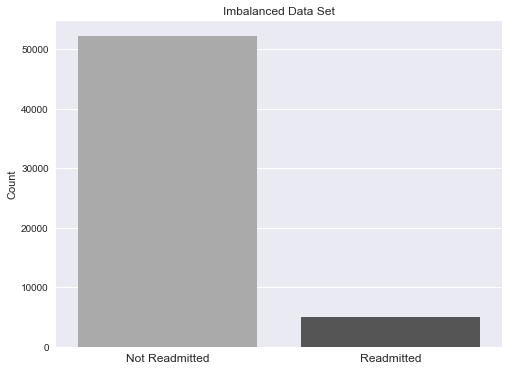

In [27]:
plt.figure(figsize=(8,6))
sns.countplot(y_train, palette='binary')
sns.despine()
sns.set_style('whitegrid')
plt.title('Imbalanced Data Set')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'], size = 12)
plt.xlabel('')
plt.ylabel('Count')
plt.show()

In [28]:
# SMOTE 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=123)
X_train_smo, y_train_smo = sm.fit_sample(X_train, y_train)

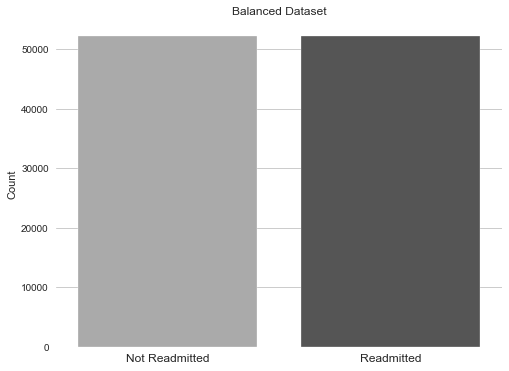

In [29]:
plt.figure(figsize=(8,6))
sns.countplot(y_train_smo, palette='binary')
sns.despine()
sns.set_style('whitegrid')
plt.title('Balanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'], size = 12)
plt.xlabel('')
plt.ylabel('Count')
plt.show()

## Model Base Line

In [30]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [31]:
thresh = 0.5

## Logistic regression

In [32]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 123)
lr.fit(X_train_smo, y_train_smo)

LogisticRegression(random_state=123)

In [33]:
y_train_preds = lr.predict_proba(X_train)[:,1]
y_valid_preds = lr.predict_proba(X_test)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Test:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_test,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.596
accuracy:0.912
recall:0.003
precision:0.359
specificity:1.000
prevalence:0.088
 
Test:
AUC:0.586
accuracy:0.912
recall:0.002
precision:0.250
specificity:0.999
prevalence:0.088
 


In [34]:
readmit_proba = [i[1] for i in lr.predict_proba(X_test)]
quant = pd.qcut(readmit_proba,10,labels=np.arange(1,11))
prob = {'Quantile':quant,'# Readmitted':readmit_proba,'y':y_test}

deciles_lr = pd.DataFrame(prob).sort_values('Quantile')
dec1 = deciles_lr.groupby('Quantile')['# Readmitted'].agg(['count','min','max','mean']).reset_index()
dec2 = deciles_lr.groupby(['Quantile','y']).count().reset_index()
dec2 = dec2[dec2['y']==1]
deciles_lr = pd.merge(dec2, dec1, how='inner',on ='Quantile').drop('y',1).\
        rename({'count':'Unique Patients', 'min':'Min Prob', 'mean':'Average Prob','max':'Max Prob'},axis=1)

deciles_lr = deciles_lr[deciles_lr.columns[[0,2,1,3,4,5]]]
deciles_lr['Percent Readmitted'] = deciles_lr['# Readmitted']/deciles_lr['Unique Patients']
deciles_lr['Lift'] = deciles_lr['Percent Readmitted'].apply(lambda x:10*x/deciles_lr['Percent Readmitted'].sum())
deciles_lr.style.hide_index()

Quantile,Unique Patients,# Readmitted,Min Prob,Max Prob,Average Prob,Percent Readmitted,Lift
1,1431,77,0.000228,0.048646,0.033401,0.053809,0.611298
2,1430,76,0.048660,0.061498,0.055338,0.053147,0.603781
3,1430,101,0.061502,0.071253,0.066455,0.070629,0.802393
4,1430,124,0.071257,0.080697,0.076007,0.086713,0.985116
5,1431,115,0.080731,0.091222,0.085897,0.080363,0.912978
6,1430,119,0.091245,0.103267,0.097125,0.083217,0.945394
7,1430,130,0.103273,0.117996,0.110498,0.090909,1.032783
8,1430,150,0.118066,0.138383,0.127829,0.104895,1.191673
9,1430,179,0.138393,0.169219,0.152226,0.125175,1.422063
10,1431,188,0.169232,0.944538,0.218516,0.131377,1.492520


In [35]:
tot_compdic = {'Unique Patients': [deciles_lr['Unique Patients'].sum(), deciles_lr['Unique Patients'][8] + deciles_lr['Unique Patients'][9]], 
               '# Readmitted': [deciles_lr['# Readmitted'].sum(), deciles_lr['# Readmitted'][8] + deciles_lr['# Readmitted'][9]]}

tot_compdic['Percent Readmitted'] = [tot_compdic['# Readmitted'][0]/tot_compdic['Unique Patients'][0],
                                     tot_compdic['# Readmitted'][1]/tot_compdic['Unique Patients'][1]]

tot_compdf = pd.DataFrame(tot_compdic, index = ['Random Sampling','Top 2 Quantiles'])

lr_readmit_rand = tot_compdf['Percent Readmitted'][0].round(4)
lr_readmit_top_2 = (deciles_lr['Percent Readmitted'][8] + deciles_lr['Percent Readmitted'][9]).round(4)

print('')
print(f'If the top two quantiles are targeted instead of a random sampling, the percent readmitted increases from',
      lr_readmit_rand, 'to',lr_readmit_top_2)
print('')
tot_compdf


If the top two quantiles are targeted instead of a random sampling, the percent readmitted increases from 0.088 to 0.2566



,Unique Patients,# Readmitted,Percent Readmitted
Random Sampling,14303,1259,0.088023
Top 2 Quantiles,2861,367,0.128277


In [36]:
lr_feat_dict = {'Feature':X_train_res.columns, 'Feature Importance':lr.coef_.reshape(lr.coef_.shape[1],)}
lr_feat_df = pd.DataFrame(lr_feat_dict)
lr_feat_df = lr_feat_df.sort_values('Feature Importance', ascending=False).head(10)
lr_feat_df

plt.figure()
sns.barplot(x = lr_feat_df['Feature Importance'], y = lr_feat_df['Feature'], palette = 'binary_r')
sns.set_style('whitegrid')
plt.title('Feature Importance: Logistic Regression')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

NameError: name 'X_train_res' is not defined

## Logistic Regression CV

In [ ]:
# logistic regression CV
from sklearn.linear_model import LogisticRegressionCV
lr_cv=LogisticRegressionCV(random_state = 123)
lr_cv.fit(X_train_smo, y_train_smo)

In [ ]:
y_train_preds = lr_cv.predict_proba(X_train)[:,1]
y_valid_preds = lr_cv.predict_proba(X_test)[:,1]

print('Logistic Regression CV')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Test:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_test,y_valid_preds, thresh)

In [ ]:
readmit_proba = [i[1] for i in lr_cv.predict_proba(X_test)]
quant = pd.qcut(readmit_proba,10,labels=np.arange(1,11))
prob = {'Quantile':quant,'# Readmitted':readmit_proba,'y':y_test}

decile_lrcv = pd.DataFrame(prob).sort_values('Quantile')
dec1 = decile_lrcv.groupby('Quantile')['# Readmitted'].agg(['count','min','max','mean']).reset_index()
dec2 = decile_lrcv.groupby(['Quantile','y']).count().reset_index()
dec2 = dec2[dec2['y']==1]
decile_lrcv = pd.merge(dec2, dec1, how='inner',on ='Quantile').drop('y',1).\
        rename({'count':'Unique Patients', 'min':'Min Prob', 'mean':'Average Prob','max':'Max Prob'},axis=1)

decile_lrcv = decile_lrcv[decile_lrcv.columns[[0,2,1,3,4,5]]]
decile_lrcv['Percent Readmitted'] = decile_lrcv['# Readmitted']/decile_lrcv['Unique Patients']
decile_lrcv['Lift'] = decile_lrcv['Percent Readmitted'].apply(lambda x:10*x/decile_lrcv['Percent Readmitted'].sum())
decile_lrcv.style.hide_index()

In [ ]:
tot_compdic_lrcv = {'Unique Patients': [decile_lrcv['Unique Patients'].sum(), decile_lrcv['Unique Patients'][8] + decile_lrcv['Unique Patients'][9]], 
               '# Readmitted': [decile_lrcv['# Readmitted'].sum(), decile_lrcv['# Readmitted'][8] + decile_lrcv['# Readmitted'][9]]}

tot_compdic_lrcv['Percent Readmitted'] = [tot_compdic_lrcv['# Readmitted'][0]/tot_compdic_lrcv['Unique Patients'][0],
                                      tot_compdic['# Readmitted'][1]/tot_compdic['Unique Patients'][1]]

tot_compdf_lrcv = pd.DataFrame(tot_compdic_lrcv, index = ['Random Sampling','Top 2 Quantiles'])

lr_readmit_rand = tot_compdf_lrcv['Percent Readmitted'][0].round(4)
lr_readmit_top_2 = (decile_lrcv['Percent Readmitted'][8] + decile_lrcv['Percent Readmitted'][9]).round(4)

print('')
print(f'If the top two quantiles are targeted instead of a random sampling, the percent readmitted increases from',
      lr_readmit_rand, 'to',lr_readmit_top_2)
print('')
tot_compdf_lrcv

In [ ]:
lrcv_feat_dict = {'Feature':X_train_res.columns, 'Feature Importance':lr_cv.coef_.reshape(lr.coef_.shape[1],)}
lrcv_feat_df = pd.DataFrame(lrcv_feat_dict)
lrcv_feat_df = lrcv_feat_df.sort_values('Feature Importance', ascending=False).head(10)

plt.figure()
sns.barplot(x = lrcv_feat_df['Feature Importance'], y = lrcv_feat_df['Feature'], palette = 'binary_r')
sns.set_style('whitegrid')
plt.title('Feature Importance: Logistic Regression with Cross Validation')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')